# Kaggle cats-or-dogs binary classification

* Building a convolutional neural network for binary classification of images.
* 3,000 JPG pictures of cats and dogs from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle.
* Data augmentation with ImageDataGenerator in Keras.
* History of training/validation accuracy and loss.

Train a CNN
1. 16 x 3 x 3 convolution layer
2. 2 x 2 max pooling layer
1. 32 x 3 x 3 convolution layer
2. 2 x 2 max pooling layer
1. 64 x 3 x 3 convolution layer
2. 2 x 2 max pooling layer
3. 512-neurons hidden layer (ReLU)
4. output layer (sigmoid)

Optimizer: RMSprop with learning rate = 0.001

Loss function: binary cross-entropy

## Download the cat and dog images

In [3]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ~/Downloads/cats_and_dogs_filtered.zip

--2019-07-26 21:08:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.48
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip’

/Users/johanzhuohan 100%[===================>]  65.43M  20.5MB/s    in 3.4s    

2019-07-26 21:08:05 (19.0 MB/s) - ‘/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import os
import zipfile

local_zip = '/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/Users/johanzhuohan/Downloads')
zip_ref.close()

In [5]:
base_dir = '/Users/johanzhuohan/Downloads/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_cats_names = os.listdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_dogs_names = os.listdir(train_dogs_dir)

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


## Training a Convolutional neural network without data augmentation

In [13]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

* Set the optimizer and the loss function
* Try 'sgd', or 'Adam' for optimizer

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

* Data processing with ImageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Setting EarlyStopping and ModelCheckpoint

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

* Training with checkpoints defined with EarlyStopping and ModelCheckpoint

In [17]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_steps=50,
                              callbacks=[es, mc],
                              verbose=1)

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 0.7373 - acc: 0.5616  

## Accuracy and Loss history without data augmentation

As it can be seen, while the accuracy increases and loss decreases continuously for training data set during training, the model performance on validation set does not improve a lot after the 1-2 epochs. Actually, the validation loss increases rapidly when the model is trained further, which indicates the overfitting. Therefore, there is no point in continuing training, and the early-stopping is needed for training the model.

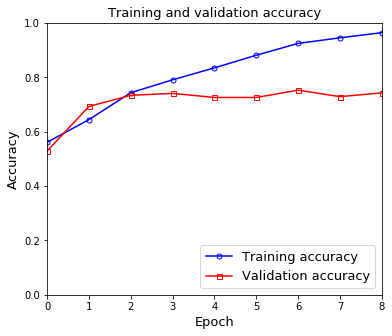

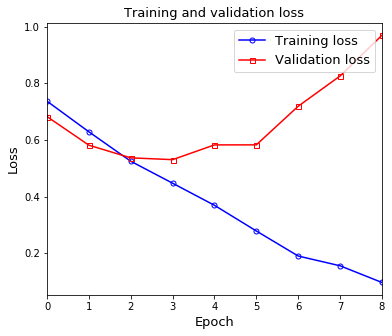

In [18]:
import matplotlib.pyplot as plt

acc = history.history[ 'acc' ]
val_acc = history.history[ 'val_acc' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs = range(len(acc)) # Get number of epochs

markers = 5
font = 13
# Accuracy
fig, ax = plt.subplots(figsize = (6,5))
ax.plot  ( epochs, acc, 'bo-', label='Training accuracy', markerfacecolor="None",markersize=markers )
ax.plot  ( epochs, val_acc, 'rs-', label='Validation accuracy', markerfacecolor="None",markersize=markers )
ax.set_title ('Training and validation accuracy', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Accuracy', fontsize=font)
ax.set(xlim=[0,epochs[-1]], ylim=[0.0,1.0])
ax.legend(loc='lower right',frameon=True,fontsize=font)

# Loss
fig, ax = plt.subplots(figsize = (6,5))
plt.plot  ( epochs, loss, 'bo-', label='Training loss', markerfacecolor="None",markersize=markers )
plt.plot  ( epochs, val_loss, 'rs-', label='Validation loss', markerfacecolor="None",markersize=markers )
plt.title ('Training and validation loss'   )
ax.set_title ('Training and validation loss', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Loss', fontsize=font)
ax.set(xlim=[0,epochs[-1]])
ax.legend(loc='upper right',frameon=True,fontsize=font)
plt.show()

## Training a Convolutional neural network with data augmentation

In addition to the early stopping of training, the overfitting of the model can also be prevented by using much larger train data set. However, if the larger data set is not accessible, ImageDataGenerator in Keras can be used to do data augmentation, e.g., rotation, zooming, flipping, of the original data set quite efficiently. Here we train the same CNN model with augmented data set with the same early stopping criterion.

In [15]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

In [16]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

* Data augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training data set
train_datagen = ImageDataGenerator( 
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest' )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   

# Validation data set
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Training with EarlyStopping and ModelCheckpoint

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [21]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_steps=50,
                              callbacks=[es, mc],
                              verbose=1)

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 0.8187 - acc: 0.5384  

## Accuracy and Loss history with data augmentation

* As it can be seen, with the aid of data augmentation, the accuracy/loss of the validation data set slowly increases/decreases with approximately the same rate with that of training data set. 
* The final best accuracy achieved for validation data set is not that different from the CNN model without data augmentation. However, the model with augmentation trained here can be trained further better if we do not set early stopping, while the accuracy of non-augmented CNN model reaches a plateau very quickly. 
* The difference is more evident for the loss of validation data set. The loss of validation set without training data augmentation start to increases rapidly after ~3-4 epochs, while the loss of validation set shown below is clearly decreasing with some fluctuations. 
* Fluctuations comes from the random augmentation treatment on the training data set. It also indicates that the variety in validation data set is relatively small, such that , and larger validation data set should be used.

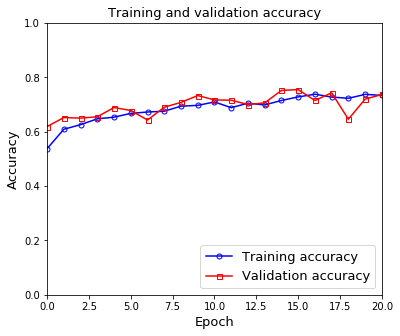

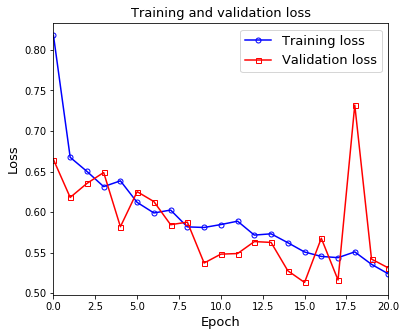

In [23]:
import matplotlib.pyplot as plt

acc = history.history[ 'acc' ]
val_acc = history.history[ 'val_acc' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs = range(len(acc)) # Get number of epochs

markers = 5
font = 13
# Accuracy
fig, ax = plt.subplots(figsize = (6,5))
ax.plot  ( epochs, acc, 'bo-', label='Training accuracy', markerfacecolor="None",markersize=markers )
ax.plot  ( epochs, val_acc, 'rs-', label='Validation accuracy', markerfacecolor="None",markersize=markers )
ax.set_title ('Training and validation accuracy', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Accuracy', fontsize=font)
ax.set(xlim=[0,epochs[-1]], ylim=[0.0,1.0])
ax.legend(loc='lower right',frameon=True,fontsize=font)

# Loss
fig, ax = plt.subplots(figsize = (6,5))
plt.plot  ( epochs, loss, 'bo-', label='Training loss', markerfacecolor="None",markersize=markers )
plt.plot  ( epochs, val_loss, 'rs-', label='Validation loss', markerfacecolor="None",markersize=markers )
plt.title ('Training and validation loss'   )
ax.set_title ('Training and validation loss', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Loss', fontsize=font)
ax.set(xlim=[0,epochs[-1]])
ax.legend(loc='upper right',frameon=True,fontsize=font)
plt.show()